# Coding assigment: Stokes Flow

Le but de cet exposé sera de résoudre le flux de Stokes dans une cavité carrée, en utilisant la formulation vorticité-fonction de courant. 
Commençons par rappeler ce que l'on entend par "Flux de Stokes": il s'agit d'un flux dominé par des forces visqueuses et non pas par les forces de convection et d'advection. Cette hypothèse fonctionne bien pour des flux caractérisés par un très petit nombre de Reynolds, c'est à dire bien plus petit que 1: très lents et visqueux, ou si l'on considère des flux à des échelles microscopiques. 

# 1. Position du problème: 

Nous allons résoudre le problème dans une cavitéà deux dimensions. Les équations du problème sont

\begin{equation}
\nabla^2 \omega = 0
\end{equation}

\begin{equation}
\nabla^2 \psi = -\omega
\end{equation}

où $\psi$ est la fonction de courant, et $\omega$ la vorticité.
On se donne les conditions aux bords suivantes: 

\begin{equation}
\psi=0
\end{equation}

sur tous les bords; 

\begin{equation}
\frac{\partial \psi}{\partial x}=0
\end{equation}

sur les bords gauches et droits de la cavité;

\begin{equation}
\frac{\partial \psi}{\partial y}=0
\end{equation}

sur le bord inférieur; et 

\begin{equation}
\frac{\partial \psi}{\partial y}=u 
\end{equation}

sur le bord supérieur, avec $u=1$.

Ces conditions sont représentées sur la figure en-dessous:

In [1]:
<img src="./figures/drivencavity.svg" width=400px> ###image de la cavité à mettre avec le notebook

SyntaxError: invalid syntax (<ipython-input-1-2898263fb19c>, line 1)

On peut montrer que les conditions aux bords sur $\psi$ et ses dérivées impliquent ces conditions sur $\omega$:

\begin{equation}
\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j-1} - \psi_{i, j-2}) - \frac{3u}{\Delta y} + \mathcal{O}(\Delta y^2)
\end{equation}

sur le bord supérieur;

\begin{equation}
\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j+1} - \psi_{i, j+2}) + \mathcal{O}(\Delta y^2)
\end{equation}

sur le bord inférieur;

\begin{equation}
\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i-1,j} - \psi_{i-2, j}) + \mathcal{O}(\Delta y^2)
\end{equation}

sur le bord droit, et

\begin{equation}
\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i+1, j} - \psi_{i+2, j}) + \mathcal{O}(\Delta y^2)
\end{equation}

sur le bord gauche.

# 2. Méthode de Jacobi: 

Les équations à résoudre sont de la forme:

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b$$

ou, sous forme discrétisée,

$$\frac{p_{i+1,j}^{k}-2p_{i,j}^{k}+p_{i-1,j}^{k}}{\Delta x^2}+\frac{p_{i,j+1}^{k}-2 p_{i,j}^{k}+p_{i,j-1}^{k}}{\Delta y^2}=b_{i,j}^{k}$$

ou encore:

$$p_{i,j}^{k}=\frac{(p_{i+1,j}^{k}+p_{i-1,j}^{k})\Delta y^2+(p_{i,j+1}^{k}+p_{i,j-1}^{k})\Delta x^2-b_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$

Ceci motive à utiliser la méthode suivante: supposer une forme initiale pour la solution, calculer une forme (la $k+1$ ème) de la solution un peu plus proche de la solution exacte avec la formule

$$p_{i,j}^{k+1}=\frac{(p_{i+1,j}^{k}+p_{i-1,j}^{k})\Delta y^2+(p_{i,j+1}^{k}+p_{i,j-1}^{k})\Delta x^2-b_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$

Ainsi, la solution devrait s'approcher de la solution finale, donc l'écart entre les itérations de la solution devraient diminuer. Nous stopperons lorsque l'itération suivante sera suffisamment proche de la précédente. La norme $L_1$ de la différence entre deux itérations devra atteindre une valeur inférieure à $10^{-6}$. C'est donc une sorte de généralisation de la méthode de Jacobi, qui s'applique aux équations de Laplace.

Puisque nous avons deux équations couplées, il faut relaxer $\omega$ et $\psi$ en même temps, donc $\omega^{k+1}$ et $\psi^{k+1}$ dans la même boucle. Les normes $L_1$ des différences entre deux itérations de $\psi$ et deux itérations de $\omega$ devront être inférieures à $10^{-6}$. A chaque étape, il faudra aussi imposer les condition de bord sur $\psi$ et $\omega$.


# 3. Résolution: 

In [27]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import cm


On écrit les fonctions calculant la différence entre les deux valeurs des fonctions après chaque itération (nouvelle valeur -ancienne valeur)


In [28]:
def L1norm(new, old):
    norm = np.sum(np.abs(new-old))
    return norm

Eciture de la fonction implémentant la méthode itérative: 

In [43]:
def Stokes2d(omega, psi, l1_target, dx,dy):
    l1normPsi=1
    l1normOmega=1
    omegan=np.zeros_like(omega)
    psin=np.zeros_like(psi)
    
    while l1normPsi>l1_target or l1normOmega>l1_target:
        omegan=omega.copy()
        psin=psi.copy()
        psi[1:-1,1:-1]=( (psin[1:-1,2:]+psin[1:-1,:-2])*dx**2\
                        +(psin[2:,1:-1]+psin[:-2,1:-1])*dy**2\
                        +omegan[1:-1,1:-1]*dx**2*dy**2\
                       )/(2*dx**2+2*dy**2)
        
        omega[1:-1,1:-1]=( (omegan[1:-1,2:]+omegan[1:-1,:-2])*dx**2\
                        +(omegan[2:,1:-1]+omegan[:-2,1:-1])*dy**2\
                         )/(2*dx**2+2*dy**2)
        
        #Conditions aux bords pour psi (bord gauche, droit, inférieur, supérieur) 
        psi[0,:]=0
        psi[-1,:]=0
        psi[:,0]=0
        psi[:,-1]=0
        
        #Conditions aux bords pour omega (dépendent de psi) dans l'ordre suivant: bord supérieur, 
        #bord inférieur, bord de droite, bord de gauche:
        omega[:,-1]=-1/(2*dy**2)*(8*psi[:,-2]-psi[:,-3])-3/dy
        omega[:,0]=-1/(2*(dy**2))*(8*psi[:,1]-psi[:,2])
        omega[-1,:]=-1/(2*(dx**2))*(8*psi[-2,:]-psi[-3,:])
        omega[0,:]=-1/(2*(dx**2))*(8*psi[1,:]-psi[2,:])
           
        l1normPsi=L1norm(psi, psin)
        l1normOmega=L1norm(omega,omegan)
    
    return psi,omega

In [44]:
#Conditions initiales:
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6

x=np.linspace(0,1,nx)
y=np.linspace(0,1,ny)

omega=np.zeros((nx,ny))
psi=np.zeros((nx,ny))

On peut maintenant lancer notre fonction:

In [45]:
#Application de la fonction:
psif,omegaf=Stokes2d(omega, psi, l1_target, dx,dy)

Pour dresser le graphique de la solution $\psi$, il faut d'abord inverser les coordonées $x$ et $y$ dans la solution, pour la visualiser dans le bon sens.

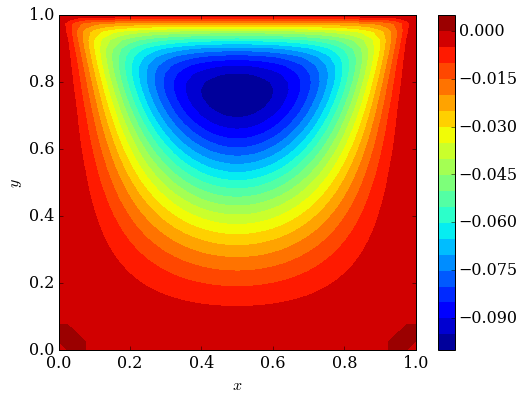

In [48]:
psiGraphique=np.zeros((nx,ny))
for i in range (nx):
    for j in range (ny):
        psiGraphique[i,j]=psif[j,i]

#Graphique
x=np.linspace(0,l,nx)
y=np.linspace(0,h,ny)
mx, my = np.meshgrid(x,y)
pyplot.figure(figsize=(8,6))
pyplot.contourf(mx,my,psiGraphique,20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

# Réponses aux questions 

Ecrivons maintenant le code pour répondre aux questions sur les solutions calculées.
La fonction $amax$ nous trouve la valeur maximale d'un tableau:

In [49]:
print(np.amax(abs(psif)))
print(np.amax(abs(omegaf)))

0.0998451724622
78.1926612286


La questions suivante demande d'exécuter le code ci-dessous:

In [50]:
np.round(psiGraphique[32,::8], 4)

array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])